# Testing ability of RNN to learn deterministic policy
This test involved <DATA_BLOCKS> Blocks of Data with <DATA_ELEMENTS_PER_BLOCK> elements.
The idea is to determine the block with the sum of elements using a policy to take glimpses of the data.  So a hard attention as in [Recurrent Models of Visual Attention](http://arxiv.org/pdf/1406.6247v1.pdf).  The glimpses are fed into a seperate network classifier which defines the probability distribution of the largest block.  A good policy would have learnt to take the glimpses containing the information most useful for the classifier in predicting the largest block.

When initially thinking about this problem I understood that a neural network could generally approximate any function but I felt sceptical that it could properly represent a deterministic nonlinear policy. So I decided to test that by manually coding what I felt would be a good policy and checking I was able to make a neural network fit that function before proceeding with reinforcement learning to properly implement hard attention.

Example of Data with DATA_BLOCKS=3 and DATA_ELEMENTS_PER_BLOCK=4

|     |  0  |  1  |  2  |
|-----|-----|-----|-----|
|  0  | 0.1 |-0.2 | 0.3 |
|  1  |-0.4 | 0.5 |-0.4 |
|  2  | 0.3 | -0.2| 0.1 |
|  3  | 0.0 | 0.1 |-0.2 |

In [21]:
from __future__ import print_function
import torch
import gym
from gym import spaces
from typing import List, TypeVar, Iterable, Tuple, Union, Callable
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
from baselines.acer.acer_simple import learn
from baselines.acer.policies import AcerCnnPolicy, AcerLstmPolicy
%matplotlib inline  
import cv2

In [6]:
DATA_BLOCKS = 5
DATA_ELEMENTS_PER_BLOCK = 5
TIMESTEPS = DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK
POLICY_HIDDEN_SIZE = 512
POLICY_LSTM_CELLS = 2
POLICY_OUTPUT_SIZE = DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK 
POLICY_LEARNING_RATE = 3e-3
POLICY_BATCH_SIZE = 8
CLASSIFIER_HIDDEN_SIZE = 128 
CLASSIFIER_LSTM_CELLS = 2
CLASSIFIER_OUTPUT_SIZE = DATA_BLOCKS 
CLASSIFIER_LEARNING_RATE = 3e-3
CLASSIFIER_BATCH_SIZE = 256
# Reduce variance for the classifier by not including loss for when predictions are highly uncertain due to limited data
CLASSIFIER_PREDICTION_DELAY = int(0.1 * DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK)
CLASSIFIER_PREDICTION_DELAY = 24 

In [4]:
def policy_glimpses_labels(x):
    """
    Simple deterministic heuristic policy that keeps checking each block to see if the next value is above the mean.
    Continues looking in the same block until it finds a value that is less than the mean.
    The idea is that if it finds a block with a lot of entries above the mean it should imply 
    that it will increase the probability that it is the largest and similarly less likely
    with values below the mean..
    """
    # Initial action
    actions = [(0, 0)]
    glimpses = np.zeros((TIMESTEPS))
    observations = np.zeros((DATA_BLOCKS, DATA_ELEMENTS_PER_BLOCK), dtype=np.int64)
    for i in range(DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK):
        action = actions[i]
        block_idx = action[0]
        element_idx = action[1]
        observations[block_idx, element_idx] = 1
        glimpses[i] = x[block_idx, element_idx]
        # Choose the next glimpse unless we have already seen all glimses.
        if (i < DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK - 1):
            same_block_if_possible = glimpses[i] > 0.
            # Loop until next unchecked element is found.
            if not same_block_if_possible:
                block_idx = (block_idx + 1) % DATA_BLOCKS 
            # Find next unchecked block
            while(True): 
                possible_unchecked = np.argmax(observations[block_idx, :] == 0)
                if observations[block_idx, possible_unchecked] == 0:
                    unchecked_element = possible_unchecked
                    break
                block_idx = (block_idx + 1) % DATA_BLOCKS
            action = (block_idx, unchecked_element)
            actions.append(action)
    action_1d = tuple(action[0] * DATA_ELEMENTS_PER_BLOCK + action[1] for action in actions)
    return (glimpses, np.array(action_1d))

In [5]:
def generate_data_and_labels():
    # Zero Mean
    state = np.random.rand(DATA_BLOCKS, DATA_ELEMENTS_PER_BLOCK) - 0.5
    sums = np.sum(state, axis=1)
    x, policy_label = policy_glimpses_labels(state)
    # policy_label_one_hot = np.eye(DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK)[policy_label]
    classifier_label = np.argmax(sums)
    return (x, policy_label, classifier_label)

In [6]:
def generate_batches(batch_size):
    x_all = np.zeros((TIMESTEPS, batch_size))
    #policy_labels = np.zeros((batch_size, DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK, DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK), dtype=np.int64)
    policy_labels = np.zeros((TIMESTEPS, batch_size), dtype=np.int64)
    classifier_labels = np.zeros((TIMESTEPS, batch_size))
    for i in range(batch_size):
        x_all[:, i], policy_labels[:, i],  classifier_labels[:, i]= generate_data_and_labels()
    return (x_all, policy_labels, classifier_labels)

In [7]:
class RNN(nn.Module):
    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size, batch_size, timesteps, lstm_cells):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.timesteps = timesteps
        
        self.lstm2o = nn.Linear(hidden_size, output_size)
        self.act_cell2o = nn.Softmax()
        self.lstm = nn.LSTM(data_size, hidden_size, lstm_cells)
        # Network must learn initial state of hidden layer.
        hidden_initial = torch.from_numpy(np.tile(np.random.rand(hidden_size), (lstm_cells, batch_size, 1)))
        cell_initial = torch.from_numpy(np.tile(np.random.rand(hidden_size), (lstm_cells, batch_size, 1)))
                              
        self.hidden0 = nn.Parameter(hidden_initial.view(lstm_cells, batch_size, hidden_size).type(torch.FloatTensor), requires_grad=True)
        self.cell0 = nn.Parameter(cell_initial.view(lstm_cells, batch_size, hidden_size).type(torch.FloatTensor), requires_grad=True)
        
        self.hidden_initial_cell = (self.hidden0, self.cell0)

    def forward(self, data, hidden=None):
        if hidden is None:
            hidden = self.hidden_initial_cell
        hidden_all, hidden_last = self.lstm(data, hidden)
        hidden_all_2d_view = hidden_all.view(self.timesteps * self.batch_size, self.hidden_size)
        output =  self.lstm2o(hidden_all_2d_view)
        output_softmax = self.act_cell2o(output)
        return (hidden, output, output_softmax)

In [8]:
policy_rnn = RNN(1, POLICY_HIDDEN_SIZE, POLICY_OUTPUT_SIZE, POLICY_BATCH_SIZE, TIMESTEPS, POLICY_LSTM_CELLS)
policy_loss_fn = nn.CrossEntropyLoss()
policy_optimizer = torch.optim.Adam(policy_rnn.parameters(), lr=POLICY_LEARNING_RATE)

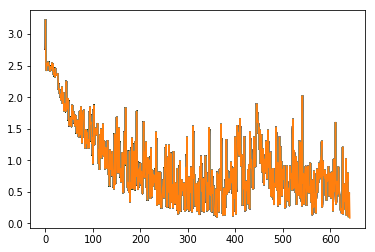

chosen_actions_example
[ 0  1  5  6 10 11 15 20  2  7  8  9 12 16 21 22  3  4 13 14 17 18 23 19
 24]
policy_lables_example
[ 0  1  5  6 10 11 15 20  2  7  8  9 12 16 21 22  3  4 13 14 17 18 23 19
 24]
error: 0.125
loss: 0.08827725052833557
Goal reached after 6410 training iterations


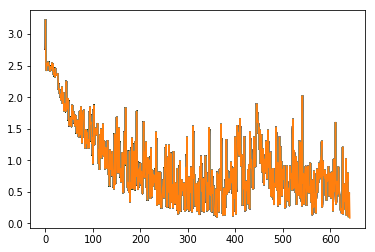

In [9]:
losses = []
for i in range(1000000):
    x_all, policy_labels, classifier_labels = generate_batches(POLICY_BATCH_SIZE)
    x_swapped = np.swapaxes(x_all, 0, 1)
    x_tensor = torch.Tensor(x_all).view(TIMESTEPS, POLICY_BATCH_SIZE, 1)
    y_tensor = torch.Tensor(policy_labels)
    policy_optimizer.zero_grad() 
    x_variable = Variable(torch.Tensor(x_tensor), requires_grad=False).type(torch.FloatTensor)
    y_variable = Variable(torch.Tensor(y_tensor), requires_grad=False).type(torch.LongTensor)
    hidden, output, output_softmax = policy_rnn(x_variable)
    loss = policy_loss_fn(output.view(TIMESTEPS * POLICY_BATCH_SIZE, POLICY_OUTPUT_SIZE), y_variable.view(TIMESTEPS * POLICY_BATCH_SIZE))
    loss.backward()
    policy_optimizer.step()
    if i % 10 == 0:
        losses.append(loss.data.numpy()[0])
        plt.plot(range(len(losses)), losses)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        chosen_action = (np.argmax(output_softmax.view(TIMESTEPS * POLICY_BATCH_SIZE, POLICY_OUTPUT_SIZE).data.numpy(), axis=1))
        print("chosen_actions_example")
        print(chosen_action.reshape(TIMESTEPS, POLICY_BATCH_SIZE)[:, 0])
        print("policy_lables_example")
        print(policy_labels.reshape(TIMESTEPS, POLICY_BATCH_SIZE)[:, 0])
        error = TIMESTEPS * np.mean(chosen_action != policy_labels.reshape(TIMESTEPS * POLICY_BATCH_SIZE))
        print("error: {}".format(error))
        print("loss: {}".format(losses[-1]))
        if losses[-1] < 0.1:
            print("Goal reached after {} training iterations".format(i))
            break

In [10]:
classifier_rnn = RNN(1, CLASSIFIER_HIDDEN_SIZE, CLASSIFIER_OUTPUT_SIZE, CLASSIFIER_BATCH_SIZE, TIMESTEPS, CLASSIFIER_LSTM_CELLS)
classifier_loss_fn = nn.CrossEntropyLoss()
classifier_optimizer = torch.optim.Adam(classifier_rnn.parameters(), lr=CLASSIFIER_LEARNING_RATE)

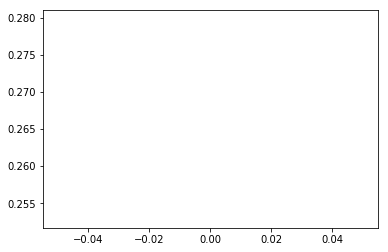

classifier output example
[1 0 0 0 0 2 1 1 1 0 4 3 3 2 4 1 0 4 1 3 2 2 4 4 3]
classifier labels example
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3.]
error: 19.78125
loss: 0.26633238792419434
Goal reached after 0 training iterations


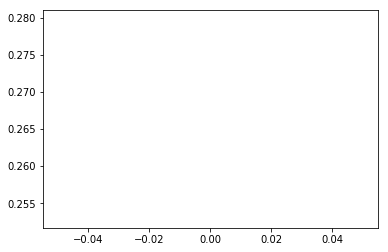

In [12]:
losses = []
for i in range(1000000):
    x_all, policy_labels, classifier_labels = generate_batches(CLASSIFIER_BATCH_SIZE)
    x_swapped = np.swapaxes(x_all, 0, 1)
    x_tensor = torch.Tensor(x_all).view(TIMESTEPS, CLASSIFIER_BATCH_SIZE, 1)
    y_tensor = torch.Tensor(classifier_labels)
    classifier_optimizer.zero_grad() 
    x_variable = Variable(torch.Tensor(x_tensor), requires_grad=False).type(torch.FloatTensor)
    y_variable = Variable(torch.Tensor(y_tensor), requires_grad=False).type(torch.LongTensor)
    hidden, output, output_softmax = classifier_rnn(x_variable)
    output_limited = output.view(TIMESTEPS, CLASSIFIER_BATCH_SIZE, CLASSIFIER_OUTPUT_SIZE)[CLASSIFIER_PREDICTION_DELAY:, :, :]
    y_variable_limited = y_variable.view(TIMESTEPS, CLASSIFIER_BATCH_SIZE)[CLASSIFIER_PREDICTION_DELAY:, :]
    loss = classifier_loss_fn(output_limited.view((TIMESTEPS - CLASSIFIER_PREDICTION_DELAY) * CLASSIFIER_BATCH_SIZE, CLASSIFIER_OUTPUT_SIZE),
                              y_variable_limited.view((TIMESTEPS - CLASSIFIER_PREDICTION_DELAY) * CLASSIFIER_BATCH_SIZE))
    loss.backward()
    classifier_optimizer.step()
    if i % 10 == 0:
        losses.append(loss.data.numpy()[0])
        plt.plot(range(len(losses)), losses)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        prediction = (np.argmax(output_softmax.view(TIMESTEPS * CLASSIFIER_BATCH_SIZE, CLASSIFIER_OUTPUT_SIZE).data.numpy(), axis=1))
        print("classifier output example")
        print(prediction.reshape(TIMESTEPS, CLASSIFIER_BATCH_SIZE)[:, 0])
        print("classifier labels example")
        print(classifier_labels.reshape(TIMESTEPS, CLASSIFIER_BATCH_SIZE)[:, 0])
        error = TIMESTEPS * np.mean(prediction != classifier_labels.reshape(TIMESTEPS * CLASSIFIER_BATCH_SIZE))
        print("error: {}".format(error))
        print("loss: {}".format(losses[-1]))
        if losses[-1] < 0.5:
            print("Goal reached after {} training iterations".format(i))
            break

In [34]:
np.array([-0.5]).reshape([1,1,1]).shape

(1, 1, 1)

In [35]:
class MaxBlockEnd(gym.Env):
    def __init__(self, render: bool=False) -> None:
        self.observation_space = spaces.Box(low=np.array([-0.5]).reshape([1,1,1]),
                                            high=np.array([0.5]).reshape([1,1,1]),
                                            dtype=np.float32)
        # Action space is action space for glimpses (total number of blocks) + The classifier output.
        # This may be a little wierd but it should allow me to use baselines rather than writing a customer
        # implementation with a seperate classifier network..
        self.action_space = spaces.Discrete(DATA_BLOCKS * DATA_ELEMENTS_PER_BLOCK + DATA_BLOCKS)
        self.num_envs = 1
        self.remotes = [] 
        # self._seed()

    def _step(self, action: Tuple[int]) -> Tuple[float, float, bool, dict]:
        self.attention = action[0]
        self.classifier_label = action[1]
        self._observation = self.world_state[self.attention]
        reward = int(self.solution != self.classifier_label)
        done = self.environment_steps_counter >= TIMESTEPS
        return (self._observation, reward, done, {})

    def reset(self) -> float:
        self.world_state = np.random.rand(DATA_BLOCKS, DATA_ELEMENTS_PER_BLOCK) - 0.5
        sums = np.sum(world_state, axis=1)
        self.solution = np.argmax(sums)
        self.action = 0
        self._observation = self.world_state[self.attention]
        self.environment_steps_counter = 0
        return self._observation

    def _render(self, mode='human', close=False) -> None:
        pass


In [36]:
env = MaxBlockEnd()

In [37]:
env.observation_space

Box(1, 1, 1)

In [38]:
learn(AcerLstmPolicy, env, 0, total_timesteps=int(10000 * 1.1), lrschedule="constant")

Running Acer Simple
{'delta': 1, 'alpha': 0.99, 'trust_region': True, 'c': 10.0, 'replay_start': 10000, 'replay_ratio': 4, 'buffer_size': 50000, 'log_interval': 100, 'gamma': 0.99, 'rprop_alpha': 0.99, 'rprop_epsilon': 1e-05, 'lrschedule': 'constant', 'lr': 0.0007, 'max_grad_norm': 10, 'ent_coef': 0.01, 'q_coef': 0.5, 'total_timesteps': 11000, 'nstack': 4, 'nsteps': 20, 'seed': 0, 'env': <__main__.MaxBlockEnd object at 0x127466f98>, 'policy': <class 'baselines.acer.policies.AcerLstmPolicy'>}


ValueError: Negative dimension size caused by subtracting 8 from 1 for 'model/c1/Conv2D' (op: 'Conv2D') with input shapes: [1,1,1,4], [8,8,4,32].